Saving international-airline-passengers.csv to international-airline-passengers (4).csv


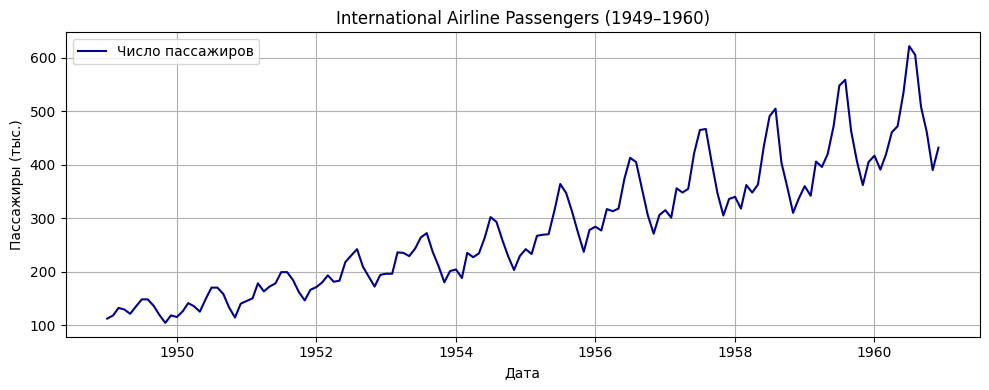

In [6]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка файла через интерфейс
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Загружаем с явным указанием названий столбцов и пропуском плохих строк
df = pd.read_csv(filename, skiprows=1, names=["Month", "Passengers"])

# Удаляем строки с пропущенными значениями или заголовком случайно в данных
df = df[df['Month'].str.match(r'\d{4}-\d{2}', na=False)]
df = df.dropna()

# Преобразуем дату
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['Passengers'] = df['Passengers'].astype(float)
df.set_index('Month', inplace=True)

# Визуализация
plt.figure(figsize=(10, 4))
plt.plot(df['Passengers'], label='Число пассажиров', color='darkblue')
plt.title('International Airline Passengers (1949–1960)')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#План следующих действий

1. Обучим Скрытую Марковскую модель (HMM) на этом временном ряде;

2. Получим скрытые состояния для каждой точки;

3. Построим наивный прогноз — по средним значениям состояний.



In [7]:
!pip install hmmlearn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.6 MB/s eta 0:00:00


In [8]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Преобразуем временной ряд в формат (n_samples, n_features)
X = df['Passengers'].values.reshape(-1, 1)

# Инициализируем и обучаем HMM
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000, random_state=42)
model.fit(X)

# Предсказание скрытых состояний
hidden_states = model.predict(X)

# Добавим в DataFrame для наглядности
df['State'] = hidden_states


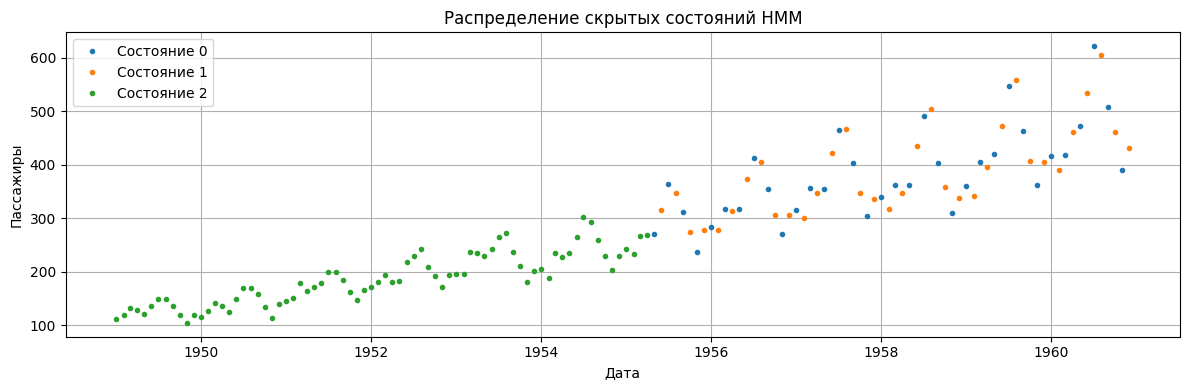

In [9]:
plt.figure(figsize=(12, 4))
for state in np.unique(hidden_states):
    mask = df['State'] == state
    plt.plot(df.index[mask], df['Passengers'][mask], '.', label=f'Состояние {state}')
plt.title('Распределение скрытых состояний HMM')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Комментарии по графику:

Состояние 2 (зелёное) — соответствует раннему периоду (1949–1954), когда пассажиропоток был стабильным и низким;

Состояние 0 (синее) и Состояние 1 (оранжевое) — отражают более поздние годы, при этом:

вероятно, состояние 1 описывает пиковые периоды (летние всплески);

состояние 0 — возможно, характеризует межсезонье или периоды стабильного роста.

**Модель действительно смогла сегментировать ряд по динамике, что говорит о том, что:**

HMM хорошо подходит для кластеризации фаз во временных рядах;

Скрытые состояния можно использовать для упрощённого прогнозирования, например, через среднее по каждому состоянию.



#Наивный прогноз на основе скрытых состояний HMM

In [10]:
# Считаем среднее значение по каждому состоянию
state_means = df.groupby('State')['Passengers'].mean().to_dict()

# Строим наивный прогноз — просто подставляем среднее по состоянию
df['NaiveForecast'] = df['State'].map(state_means)


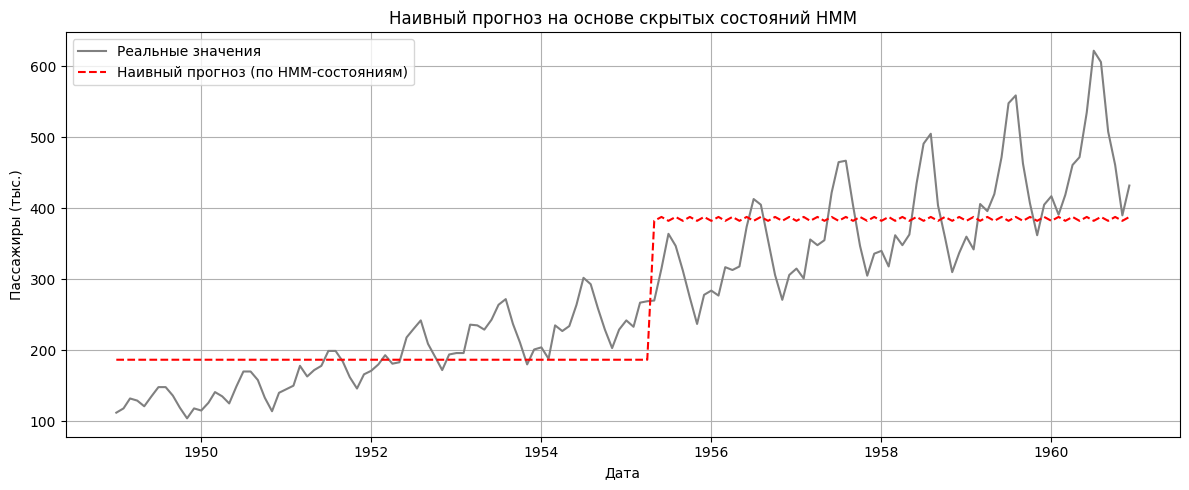

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(df['Passengers'], label='Реальные значения', color='gray')
plt.plot(df['NaiveForecast'], label='Наивный прогноз (по HMM-состояниям)', color='red', linestyle='--')
plt.title('Наивный прогноз на основе скрытых состояний HMM')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(df['Passengers'], df['NaiveForecast'])
rmse = np.sqrt(mse)

print(f'RMSE наивного прогноза: {rmse:.2f}')


RMSE наивного прогноза: 66.87


#Комментарий по результату:

Прогноз повторяет форму данных кусково-постоянной линией — это ожидаемо, ведь каждое скрытое состояние даёт одно усреднённое значение;

HMM хорошо отразила смену фаз роста, особенно в районе 1954–1955 года, где прогноз резко изменился;

Конечно, модель не ловит сезонные пики, но в целом угадывает уровень.